In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

import cge_modeling as cge
from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [100]:
df = pd.read_csv("../data/factor_tax.csv", index_col=[0, 1], header=[0, 1]).fillna(0)
np.testing.assert_allclose(df.sum(axis=0).values, df.sum(axis=1).values)

In [101]:
sectors = ["Milk", "Bread"]
n_sectors = 2
coords = {"i": sectors, "j": sectors}

In [119]:
variables = [
    # Firm Variables
    Variable(name="Y", dims=("i",), description="Output", positive=True),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims=("i",),
        extend_subscript=True,
        description="<dim:i> sector demand for labor",
        positive=True,
    ),
    Variable(
        name="K_d",
        dims=("i",),
        extend_subscript=True,
        description="><dim:i> sector demand for capital",
        positive=True,
    ),
    Variable(
        name="I_d",
        dims=("i",),
        extend_subscript=True,
        description="<dim:i> sector demand for investment capital",
        positive=True,
    ),
    # Household variables
    Variable(name="C", dims=("i",), description="Consumption", positive=True),
    Variable(name="I", description="Investment", positive=True),
    Variable(name="U", description="Household utility"),
    Variable(name="income", description="Household income", latex_name="Omega", positive=True),
    Variable(
        name="net_income", description="Household after-tax income", latex_name="\\hat{\\Omega}"
    ),
    Variable("I_s", description="Total supply of investment capital"),
    # Government variables
    Variable(name="G", description="Total government non-investment spending"),
    Variable(
        name="C_G",
        dims=("i",),
        extend_subscript=True,
        description="Government consumption of <dim:i>",
    ),
    # Price system
    Variable(name="r", description="Rental rate of capital", positive=True),
    Variable(name="w", description="Wage level", positive=True),
    Variable(
        name="r_star",
        latex_name="r^\\star",
        dims=("i",),
        description="<dim:i> after-tax rental rate",
        positive=True,
    ),
    Variable(
        name="w_star",
        dims=("i",),
        latex_name="w^\\star",
        description="<dim: i> after-tax wage level",
        positive=True,
    ),
    Variable(name="P", dims=("i",), description="<dim:i> price level", positive=True),
    Variable(
        name="P_Y",
        dims=("i",),
        extend_subscript=True,
        description="<dim: i> producer price level",
        positive=True,
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(name="resid", latex_name="varepsilon", description="Walrasian residual"),
]

parameters = [
    Parameter(name="L_s", description="Household labor supply"),
    Parameter(name="K_s", description="Household capital supply"),
    Parameter(
        name="alpha_C",
        dims=("i",),
        extend_subscript=True,
        description="Share of <dim:i> in household consumption",
    ),
    Parameter(
        name="epsilon_C",
        description="Household elasticity of substitution between consumption goods",
    ),
    Parameter(name="mpc", latex_name="phi", description="Household marginal propensity to consume"),
    Parameter(name="I_G", description="Government investment"),
    Parameter(
        name="alpha_G", dims=("i",), description="Share of <dim: i> in government consumption"
    ),
    Parameter(name="tau_income", latex_name="\\tau_Y", description="Income tax rate"),
    Parameter(
        name="tau_sales",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_P",
        description="Sales tax rate in sector <dim:i>",
    ),
    Parameter(
        name="tau_capital",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_r",
        description="Capital income tax in sector <dim:i>",
    ),
    Parameter(
        name="tau_wage",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_w",
        description="Payroll tax in sector <dim:i>",
    ),
    Parameter(name="A", dims=("i",), description="Total factor productivity in sector <dim:i>"),
    Parameter(
        name="epsilon",
        dims=("i",),
        description="Elasticity of substitution between capital and labor in sector <dim:i>",
    ),
    Parameter(
        name="alpha", dims=("i",), description="Share of capital in production for sector <dim:i>"
    ),
    Parameter(
        name="alpha_I", dims=("i",), description="Share of total investment demanded by <dim:i>"
    ),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter("P_bar", description="Numeraire price level"),
]

equations = [
    # Firm equations
    ## Final output
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital bundle", "VA = psi_VA * Y"),
    ## Value chain process (intermediate goods bundle)
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        #              'VC * P_VC = (P[:, None] * X).sum(axis=0).ravel()'),
        "VC * P_VC = Sum(P_Y.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), "
        + f"(j, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> goods as production input",
        # 'X = psi_X * VC[None]'
        "X = psi_X * VC.subs({i:j})",
    ),
    ## Value add bundle (factor bundle)
    Equation(
        name="Sector <dim:i> production of labor-capital bundle",
        equation="VA = A * (alpha * K_d ** ((epsilon - 1) / epsilon) +"
        "(1 - alpha) * L_d ** ((epsilon - 1) / epsilon)) ** (epsilon / (epsilon - 1))",
    ),
    Equation(
        name="Sector <dim:i> capital demand",
        equation="K_d = VA / A * (alpha * A * P_VA / r_star) ** epsilon",
    ),
    Equation(
        name="Sector <dim:i> labor demand",
        equation="L_d = VA / A * ((1 - alpha) * A * P_VA / w_star) ** epsilon",
    ),
    Equation(name="Sector <dim:i> investment demand", equation="P_Y * I_d = alpha_I * I_s"),
    #     Household equations
    Equation(name="Utility", equation=f"U = Product(C ** alpha_C, (i, 0, {n_sectors - 1}))"),
    Equation(
        name="Household demand for good <dim:i>", equation="P * C = alpha_C * net_income * mpc"
    ),
    Equation(name="Household income", equation="income = w * L_s + r * K_s"),
    Equation(name="Net household income", equation="net_income = (1 - tau_income) * income"),
    Equation(name="Household savings", equation="I = (1 - mpc) * net_income"),
    # Government equations
    Equation(name="Price level of sector <dim:i>", equation="P = (1 + tau_sales) * P_Y"),
    Equation(name="Net rental rate in sector <dim:i>", equation="r_star = (1 + tau_capital) * r"),
    Equation(name="Net wage level in sector <dim:i>", equation="w_star = (1 + tau_wage) * w"),
    Equation(
        name="Government budget constraint",
        equation="G + I_G = tau_income * income + "
        #                       "(tau_sales * P_Y  * Y + tau_capital * r * K_d + tau_wage * w * L_d).sum()"
        f"Sum(tau_sales * P_Y  * C + tau_capital * r * K_d + tau_wage * w * L_d, (i, 0, {n_sectors - 1}))",
    ),
    Equation("Government consumption of <dim:i> sector goods", "P_Y * C_G = alpha_G * G"),
    # Equlibrium conditions
    Equation(
        name="Sector <dim:i> goods market clearing",
        equation=f"Y = C + I_d + C_G + Sum(X, (j, 0, {n_sectors - 1}))",
    ),
    Equation(name="Labor market clearing", equation=f"L_s = Sum(L_d, (i, 0, {n_sectors - 1}))"),
    Equation(name="Capital market clearing", equation=f"K_s = Sum(K_d, (i, 0, {n_sectors - 1}))"),
    Equation(name="Investment market clearing", equation="I_s = I + I_G + resid"),
    Equation(name="Numeraire", equation='P.subs({i:"Milk"}) = P_bar'),
]

In [120]:
for eq in mod.unpacked_equation_symbols:
    display(eq)

-P_VA_Milk*VA_Milk - P_VC_Milk*VC_Milk + P_Y_Milk*Y_Milk

-P_VA_Bread*VA_Bread - P_VC_Bread*VC_Bread + P_Y_Bread*Y_Bread

VC_Milk - Y_Milk*psi_VC_Milk

VC_Bread - Y_Bread*psi_VC_Bread

VA_Milk - Y_Milk*psi_VA_Milk

VA_Bread - Y_Bread*psi_VA_Bread

P_VC_Milk*VC_Milk - P_Y_Bread*X_Bread_Milk - P_Y_Milk*X_Milk_Milk

P_VC_Bread*VC_Bread - P_Y_Bread*X_Bread_Bread - P_Y_Milk*X_Milk_Bread

-VC_Milk*psi_X_Milk_Milk + X_Milk_Milk

-VC_Bread*psi_X_Milk_Bread + X_Milk_Bread

-VC_Milk*psi_X_Bread_Milk + X_Bread_Milk

-VC_Bread*psi_X_Bread_Bread + X_Bread_Bread

-A_Milk*(K_d_Milk**((epsilon_Milk - 1)/epsilon_Milk)*alpha_Milk + L_d_Milk**((epsilon_Milk - 1)/epsilon_Milk)*(1 - alpha_Milk))**(epsilon_Milk/(epsilon_Milk - 1)) + VA_Milk

-A_Bread*(K_d_Bread**((epsilon_Bread - 1)/epsilon_Bread)*alpha_Bread + L_d_Bread**((epsilon_Bread - 1)/epsilon_Bread)*(1 - alpha_Bread))**(epsilon_Bread/(epsilon_Bread - 1)) + VA_Bread

K_d_Milk - VA_Milk*(A_Milk*P_VA_Milk*alpha_Milk/r_star_Milk)**epsilon_Milk/A_Milk

K_d_Bread - VA_Bread*(A_Bread*P_VA_Bread*alpha_Bread/r_star_Bread)**epsilon_Bread/A_Bread

L_d_Milk - VA_Milk*(A_Milk*P_VA_Milk*(1 - alpha_Milk)/w_star_Milk)**epsilon_Milk/A_Milk

L_d_Bread - VA_Bread*(A_Bread*P_VA_Bread*(1 - alpha_Bread)/w_star_Bread)**epsilon_Bread/A_Bread

I_d_Milk*P_Y_Milk - I_s*alpha_I_Milk

I_d_Bread*P_Y_Bread - I_s*alpha_I_Bread

U - (C_Bread**((epsilon_C - 1)/epsilon_C)*alpha_C_Bread + C_Milk**((epsilon_C - 1)/epsilon_C)*alpha_C_Milk)**(epsilon_C/(epsilon_C - 1))

P_C - (P_Bread**(1 - epsilon_C)*alpha_C_Bread**epsilon_C + P_Milk**(1 - epsilon_C)*alpha_C_Milk**epsilon_C)**(1/(1 - epsilon_C))

C_Milk - mpc*net_income*(P_C*alpha_C_Milk/P_Milk)**epsilon_Milk

C_Bread - mpc*net_income*(P_C*alpha_C_Bread/P_Bread)**epsilon_Bread

-K_s*r - L_s*w + income

-income*(1 - tau_income) + net_income

I - net_income*(1 - mpc)

P_Milk - P_Y_Milk*(tau_sales_Milk + 1)

P_Bread - P_Y_Bread*(tau_sales_Bread + 1)

-r*(tau_capital_Milk + 1) + r_star_Milk

-r*(tau_capital_Bread + 1) + r_star_Bread

-w*(tau_wage_Milk + 1) + w_star_Milk

-w*(tau_wage_Bread + 1) + w_star_Bread

-C_Bread*P_Y_Bread*tau_sales_Bread - C_Milk*P_Y_Milk*tau_sales_Milk + G + I_G - K_d_Bread*r*tau_capital_Bread - K_d_Milk*r*tau_capital_Milk - L_d_Bread*tau_wage_Bread*w - L_d_Milk*tau_wage_Milk*w - income*tau_income

C_G_Milk*P_Y_Milk - G*alpha_G_Milk

C_G_Bread*P_Y_Bread - G*alpha_G_Bread

-C_G_Milk - C_Milk - I_d_Milk - X_Milk_Bread - X_Milk_Milk + Y_Milk

-C_Bread - C_G_Bread - I_d_Bread - X_Bread_Bread - X_Bread_Milk + Y_Bread

-L_d_Bread - L_d_Milk + L_s

-K_d_Bread - K_d_Milk + K_s

-I - I_G + I_s - resid

P_Milk - P_bar

In [121]:
mod = cge.CGEModel(
    variables=variables,
    parameters=parameters,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
    backend="numba",
    compile=True,
)

n_eq = mod.n_equations
n_var = mod.n_variables
assert n_eq == n_var, f"{n_eq} equations, {n_var} variables"

In [122]:
mod.equation_table()

<IPython.core.display.Latex object>

In [123]:
def get_CES_params(fac1, fac2, p1, p2, output, epsilon):
    _rho = (epsilon - 1) / epsilon
    alpha = p1 * fac1 ** (1 / epsilon) / ((p1 * fac1 ** (1 / epsilon) + p2 * fac2 ** (1 / epsilon)))
    A = output * (alpha * fac1**_rho + (1 - alpha) * fac2**_rho) ** (-1 / _rho)
    return A, alpha

In [124]:
def calibrate_model(
    *,
    sales_tax_payment,
    income_tax_payment,
    capital_tax_payment,
    wage_tax_payment,
    Y,
    X,
    C,
    I,
    I_d,
    C_G,
    I_G,
    K_d,
    L_d,
    epsilon,
    epsilon_C,
    mod
):
    from copy import deepcopy

    rho = (epsilon - 1) / epsilon
    rho_C = (epsilon_C - 1) / epsilon_C

    # Normalized prices
    w = 1.0
    resid = 0.0
    r = 1.0

    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)

    # Tax Rates
    tau_sales = sales_tax_payment / C
    tau_capital = capital_tax_payment / K_d
    tau_wage = wage_tax_payment / L_d

    P = P_Y * (1 + tau_sales)
    r_star = r * (1 + tau_capital)
    w_star = w * (1 + tau_wage)

    # Normalize demands
    #     K_d /= r_star
    #     L_d /= w_star

    #     X /= P[:, None]
    #     Y /= P
    #     C /= P
    #     C_G /= P
    #     I_d /= P

    # Factor supply
    L_s = L_d.sum()
    K_s = K_d.sum()

    # Numeraire
    P_bar = P[0]

    # Firm calibration
    VA = (K_d * r_star + L_d * w_star) / P_VA
    VC = (P_Y[:, None] * X).sum(axis=0) / P_VC
    A, alpha = get_CES_params(K_d, L_d, r_star, w_star, VA, epsilon)
    #     VA = A * (alpha * K_d ** rho + (1 - alpha) * L_d ** rho) ** (1 / rho)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    income = r * K_s + w * L_s
    tau_income = income_tax_payment / income
    net_income = (1 - tau_income) * income

    mpc = 1 - I / net_income
    consumption_spend = mpc * net_income
    alpha_C = C * P / consumption_spend
    U = (C**alpha_C).prod()

    G = C_G.sum()
    alpha_G = C_G / G

    I_s = (I_d).sum()
    alpha_I = P_Y * I_d / I_s

    d = {}
    for obj in mod.variables + mod.parameters:
        d[obj.name] = deepcopy(locals()[obj.name])

    return d

In [125]:
from copy import deepcopy

initial_data = {
    "Y": df["Production"].values.sum(axis=0),
    "K_d": df.loc[("Factor", "Capital"), "Activities"],
    "L_d": df.loc[("Factor", "Labor"), "Activities"],
    "X": df.loc["Production", "Activities"],
    "C": df.loc["Production", ("Institution", "Household")],
    "I": df.loc[("Other", "Investment"), ("Institution", "Household")],
    "I_d": df.loc["Production", ("Other", "Investment")],
    "C_G": df.loc["Production", ("Institution", "Govt")],
    "I_G": df.loc[("Other", "Investment"), ("Institution", "Govt")],
    "sales_tax_payment": df.loc["Sales Tax", ("Institution", "Household")],
    "income_tax_payment": df.loc[("Income Tax", "Household"), ("Institution", "Household")],
    "capital_tax_payment": df.loc[("Use Tax", "Capital"), "Production"],
    "wage_tax_payment": df.loc[("Use Tax", "Labor"), "Production"],
}

initial_data = {
    k: deepcopy(v.values) if hasattr(v, "values") else v for k, v in initial_data.items()
}

econometric_estimates = {"epsilon": np.full(n_sectors, 3), "epsilon_C": 10}

calibrated_data = calibrate_model(mod=mod, **(initial_data | econometric_estimates))

In [126]:
calibrated_data

{'Y': array([ 9200., 10200.]),
 'VA': array([6000., 8400.]),
 'VC': array([3200., 1800.]),
 'X': array([[1500.,  700.],
        [1700., 1100.]]),
 'L_d': array([2000., 6000.]),
 'K_d': array([2500.,  700.]),
 'I_d': array([1000.,  400.]),
 'C': array([2000., 5830.]),
 'I': 1270.0,
 'U': 4452.647503782687,
 'income': 11200.0,
 'net_income': 10400.0,
 'I_s': 1400.0,
 'G': 5170.0,
 'C_G': array([4000., 1170.]),
 'r': 1.0,
 'w': 1.0,
 'r_star': array([1.4       , 1.71428571]),
 'w_star': array([1.25, 1.2 ]),
 'P': array([1.15      , 1.17152659]),
 'P_Y': array([1., 1.]),
 'P_VA': array([1., 1.]),
 'P_VC': array([1., 1.]),
 'resid': 0.0,
 'L_s': 8000.0,
 'K_s': 3200.0,
 'alpha_C': array([0.25191676, 0.74808324]),
 'epsilon_C': 10,
 'mpc': 0.8778846153846154,
 'I_G': 130.0,
 'alpha_G': array([0.77369439, 0.22630561]),
 'tau_income': 0.07142857142857142,
 'tau_sales': array([0.15      , 0.17152659]),
 'tau_capital': array([0.4       , 0.71428571]),
 'tau_wage': array([0.25, 0.2 ]),
 'A': arra

In [127]:
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [128]:
idata_sim = mod.simulate(
    initial_state=calibrated_data,
    final_delta_pct={"tau_wage": [1.0, 0.0]},
    use_euler_approximation=True,
    optimizer_mode="root",
    method="hybr",
)

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/scipy/optimize/_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,


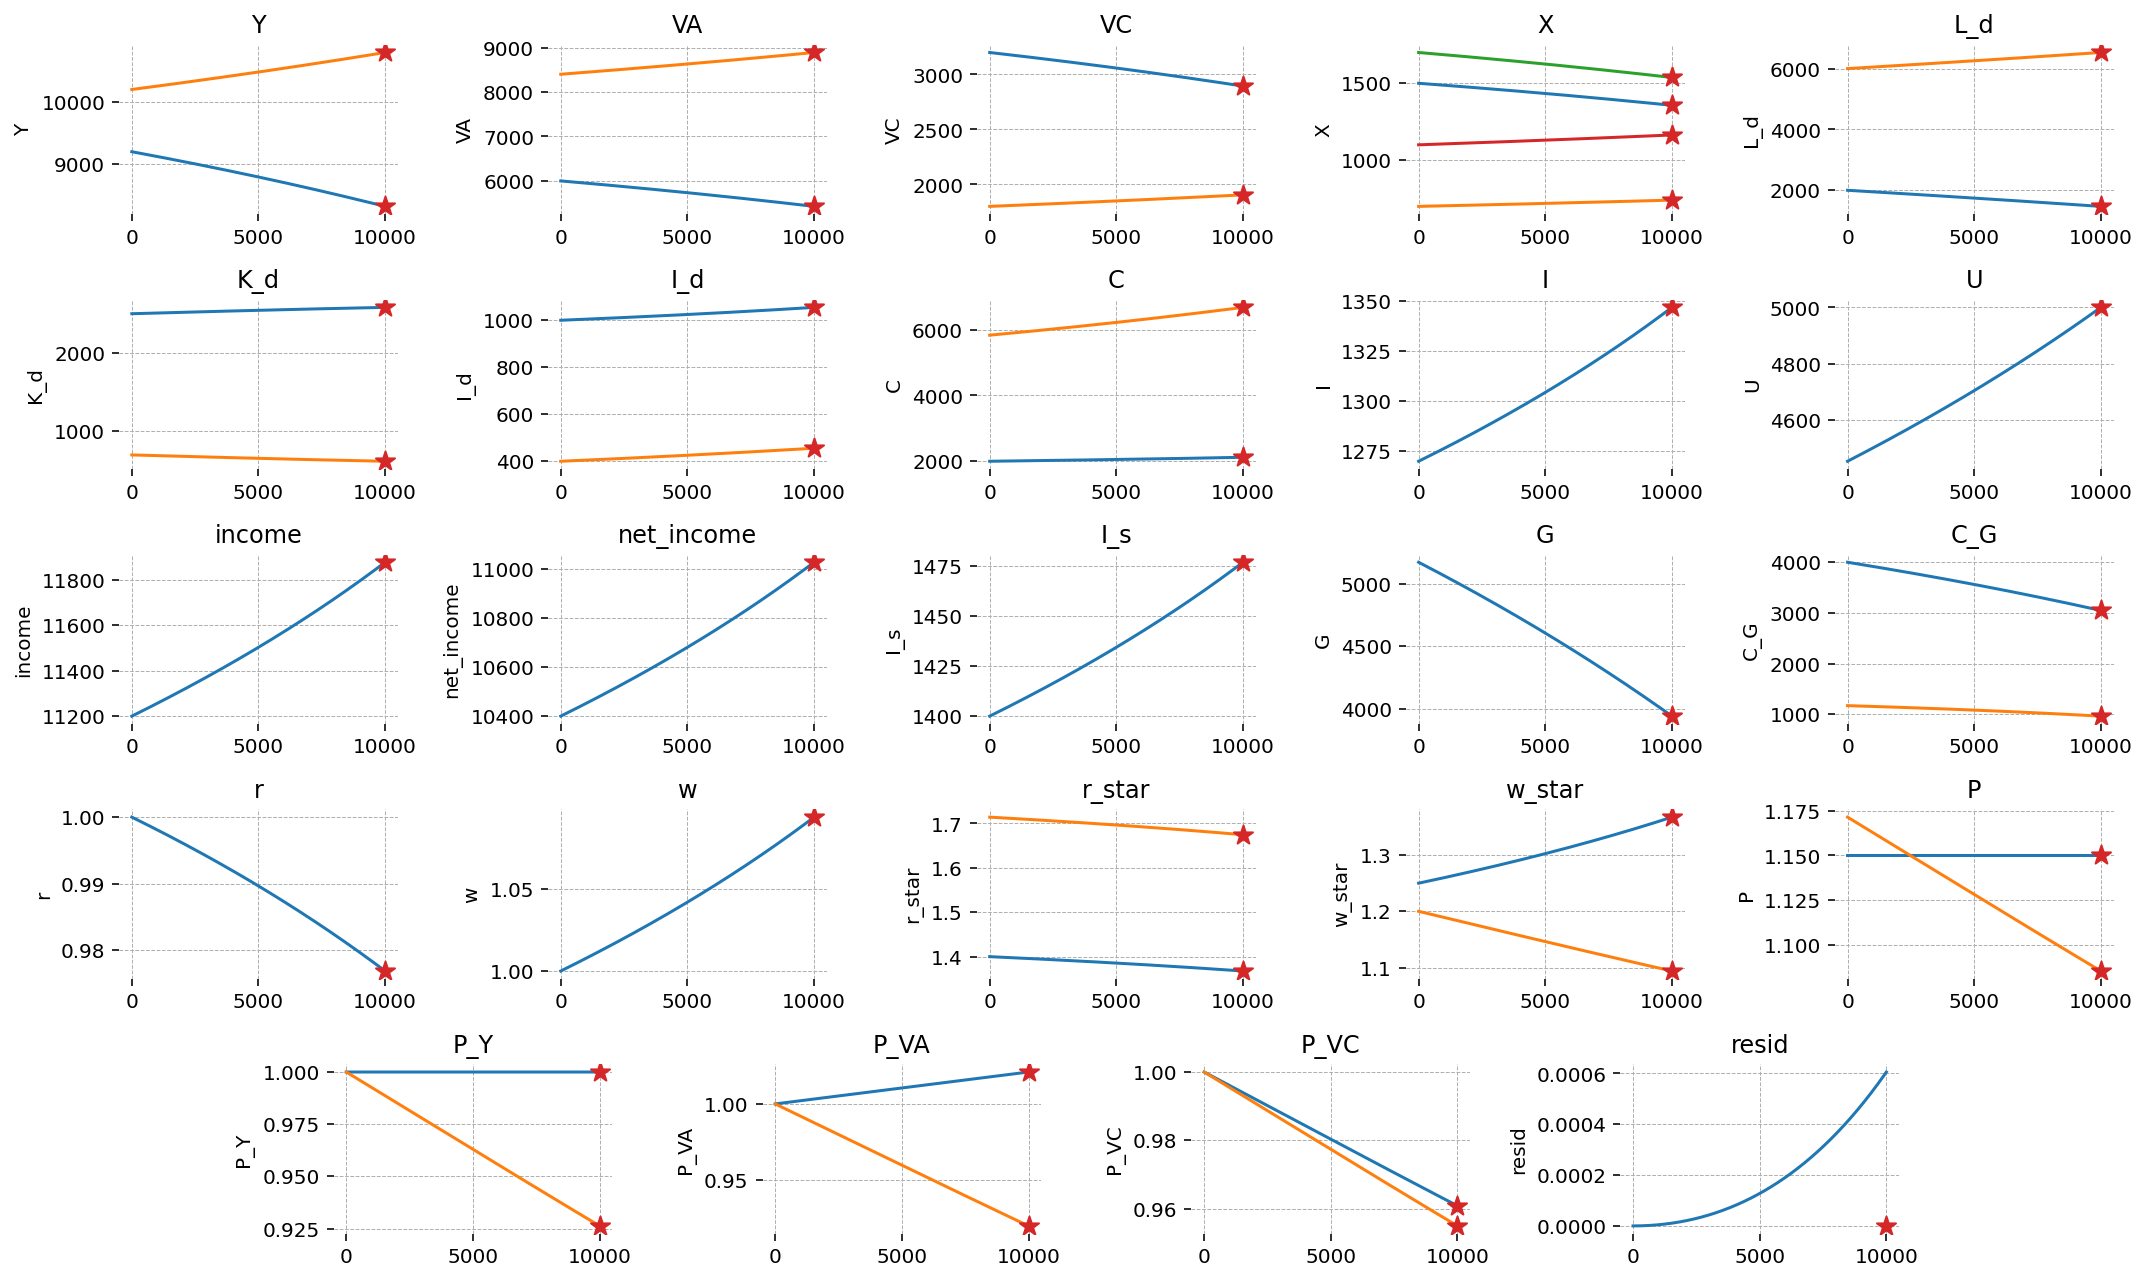

In [129]:
cge.plot_lines(idata_sim, mod)

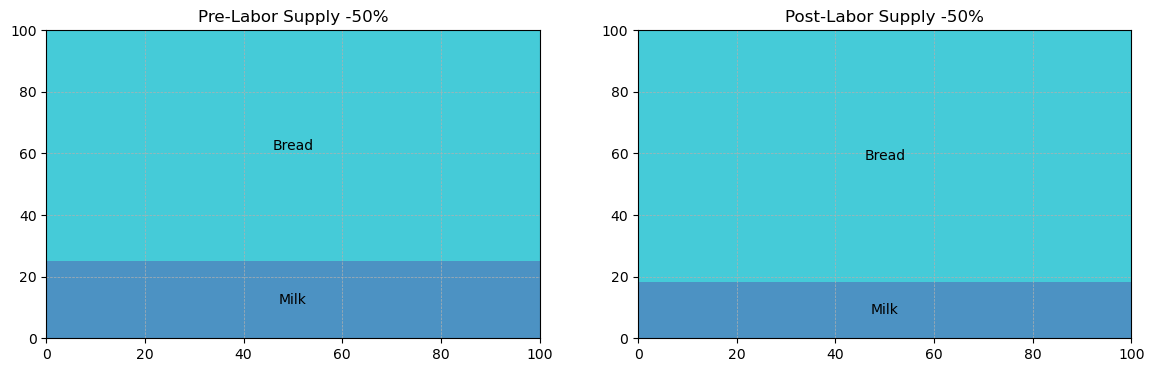

In [130]:
cge.plot_kateplot(
    idata_sim,
    initial_values=calibrated_data,
    var_names=["L_d"],
    shock_name="Labor Supply -50%",
    mod=mod,
)